# Определение перспективного тарифа для телеком-компании

## 1. Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st

tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')
messages = pd.read_csv('messages.csv')
internet = pd.read_csv('internet.csv')
calls = pd.read_csv('calls.csv')

display(tariffs.head(), users.head(), messages.head(), internet.head(), calls.head())
print(tariffs.info(), users.info(), messages.info(), internet.info(), calls.info())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null  

Для начала нужно посмотреть на имеющиеся данные. В данном случае это 5 таблиц, содержащие информацию о пользователях, тарифах, звонках, сообщениях, интернет-траффике. Таблица о тарифах состоит из двух строк и соответственно содержит данные о двух тарифах smart и ultra, в них описаны тарифные условия, пропусков нет, типы данных - int.  В ней ничего менять не нужно.
Таблица о пользователях содержит информацию об id, возрасте, дате прекращения пользования тарифом, городе, дате регистрации, имени и фамилии, и тарифе. В этой таблице пропуски есть только в столбце churn_date, но они там и должны быть, т.к. большая часть пользователей продолжает пользоваться тарифом. В таблице указаны даты, однако формат данных object, потребуется предобработка. 
Таблица про сообщения содержит информацию о каждом отправленном смс, пропусков нет, но дата так же в формате object.
Таблица об интернет траффике содержит информацию о всех сессиях выхода в интернет, она не содержит пропусков, однако там есть столбец, дублирующий индексы, и дата снова в формате object
В таблице со звонками точно такая же проблема с типом даты, судя по значениям, продолжительность звонка указана в минутах и в формате десятичной дроби, это удобнее, чем минуты и секунды.

## 2.  Предобработка данных

### 2.1 Типы данных

In [2]:
# формат даты и времени во всех таблицах одинаковый, напишем функцию
def to_date(col):
    return pd.to_datetime(col, format='%Y-%m-%d')
users['reg_date'] = to_date(users['reg_date'])
users['churn_date'] = to_date(users['churn_date'])
messages['message_date'] = to_date(messages['message_date'])
internet['session_date'] = to_date(internet['session_date'])
calls['call_date'] = to_date(calls['call_date'])
#print(tariffs.info(), users.info(), messages.info(), internet.info(), calls.info())

Теперь все даты переведены в правильный формат. Я проверила это с помощью метода .info(), но его вывод загромождает тетрадь проекта.

### 2.2 Ошибки в данных

In [3]:
# display(users.describe(), internet.describe(), calls.describe()) # данные выглядят хорошо, никаких явных выбросов нет
# осталось только округлить длительность звонков до минут
calls['duration'] = np.ceil(calls['duration'])

### 2.2 Группировка по месяцам

In [4]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month #выделение месяца из даты
calls['month'] = pd.DatetimeIndex(calls['call_date']).month 
internet['month'] = pd.DatetimeIndex(internet['session_date']).month 
messages_gr = pd.pivot_table(messages, index=['user_id', 'month'], values=['message_date'], aggfunc=len).reset_index()
calls_count = pd.pivot_table(calls, index=['user_id', 'month'], values=['call_date'], aggfunc=len).reset_index()
calls_duration = pd.pivot_table(calls, index=['user_id', 'month'], values=['duration'], aggfunc=sum).reset_index()
traffic_gr = pd.pivot_table(internet, index=['user_id', 'month'], values=['mb_used'], aggfunc=sum).reset_index()

# а вот теперь пришло время округлить траффик до мегабайтов
traffic_gr['mb_used'] = np.ceil(traffic_gr['mb_used'])
traffic_gr['mb_used'] = traffic_gr['mb_used'].astype(int)
traffic_gr

,user_id,month,mb_used
0,1000,5,2254
1,1000,6,23234
2,1000,7,14004
3,1000,8,14056
4,1000,9,14569
...,...,...,...
3198,1498,10,20580
3199,1499,9,1846
3200,1499,10,17789
3201,1499,11,17964


### 2.3 Сведение в таблицу

In [5]:
df = messages_gr.merge(calls_count, how='outer', on=['user_id', 'month'])
df = df.merge(calls_duration, how='outer', on=['user_id', 'month'])
df = df.merge(traffic_gr, on=['user_id', 'month'])
df = df.merge(users, on=['user_id'], )
display(df)
display(df.info())

,user_id,month,message_date,call_date,duration,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,22.0,159.0,2254,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,60.0,43.0,172.0,23234,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,75.0,47.0,340.0,14004,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,81.0,52.0,408.0,14056,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,57.0,58.0,466.0,14569,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3197,1494,8,NaN,32.0,262.0,6591,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart
3198,1494,9,NaN,66.0,501.0,16963,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart
3199,1494,10,NaN,52.0,354.0,17768,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart
3200,1494,11,NaN,63.0,411.0,18053,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3202 entries, 0 to 3201
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       3202 non-null   int64         
 1   month         3202 non-null   int64         
 2   message_date  2706 non-null   float64       
 3   call_date     3163 non-null   float64       
 4   duration      3163 non-null   float64       
 5   mb_used       3202 non-null   int32         
 6   age           3202 non-null   int64         
 7   churn_date    186 non-null    datetime64[ns]
 8   city          3202 non-null   object        
 9   first_name    3202 non-null   object        
 10  last_name     3202 non-null   object        
 11  reg_date      3202 non-null   datetime64[ns]
 12  tariff        3202 non-null   object        
dtypes: datetime64[ns](2), float64(3), int32(1), int64(3), object(4)
memory usage: 337.7+ KB


None

Соединила поочередно таблицы messages, calls_count, calls_duration, traffic_gr и users. Получилось так, что в столбцах про звонки и смс есть пропуски. Можно заменить их на нули, т.к. в исходных таблицах этих значений не было вообще.

In [6]:
df['message_date'] = df['message_date'].fillna(0)
df['call_date'] = df['call_date'].fillna(0)
df['duration'] = df['duration'].fillna(0)
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3202 entries, 0 to 3201
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       3202 non-null   int64         
 1   month         3202 non-null   int64         
 2   message_date  3202 non-null   float64       
 3   call_date     3202 non-null   float64       
 4   duration      3202 non-null   float64       
 5   mb_used       3202 non-null   int32         
 6   age           3202 non-null   int64         
 7   churn_date    186 non-null    datetime64[ns]
 8   city          3202 non-null   object        
 9   first_name    3202 non-null   object        
 10  last_name     3202 non-null   object        
 11  reg_date      3202 non-null   datetime64[ns]
 12  tariff        3202 non-null   object        
dtypes: datetime64[ns](2), float64(3), int32(1), int64(3), object(4)
memory usage: 337.7+ KB


None

### 2.4 Помесячная выручка с каждого пользователя

In [7]:
def message_price(row): #стоимость смс
    if row['tariff'] == 'smart':
        if row['message_date'] <= 50:
            return 0
        else:
            return (row['message_date'] - 50) * 3
    else:
        if row['message_date'] <= 1000:
            return 0
        else:
            return (row['message_date'] - 1000)
df['message_price'] = df.apply(message_price, axis=1)
def calls_price(row): #стоимость звонков 
    if row['tariff'] == 'smart':
        if row['duration'] <= 500:
            return 0
        else:
            return (row['duration'] - 50) * 3 
    else:
        if row['duration'] <= 3000:
            return 0
        else:
            return (row['duration'] - 3000)
df['calls_price'] = df.apply(calls_price, axis=1)
def internet_price(row): #стоимость интернета
    if row['tariff'] == 'smart':
        if row['mb_used'] <= 15360:
            return 0
        else:
            return math.ceil((row['mb_used'] - 15360) / 1024) * 200
    else:
        if row['mb_used'] <= 30720:
            return 0
        else:
            return math.ceil((row['mb_used'] - 30720) / 1024) * 150

df['internet_price'] = df.apply(internet_price, axis=1)

def sum_per_month(row): #сумма за месяц
    if row['tariff'] == 'smart':
        return (row['message_price'] + row['calls_price'] + row['internet_price'] + 550)
    else:
        return (row['message_price'] + row['calls_price'] + row['internet_price'] + 1950)
  

df['sum_per_month'] = df.apply(sum_per_month, axis=1)
display(df)

,user_id,month,message_date,call_date,duration,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,message_price,calls_price,internet_price,sum_per_month
0,1000,5,22.0,22.0,159.0,2254,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950.0
1,1000,6,60.0,43.0,172.0,23234,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950.0
2,1000,7,75.0,47.0,340.0,14004,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950.0
3,1000,8,81.0,52.0,408.0,14056,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950.0
4,1000,9,57.0,58.0,466.0,14569,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3197,1494,8,0.0,32.0,262.0,6591,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,0.0,0.0,0,550.0
3198,1494,9,0.0,66.0,501.0,16963,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,0.0,1353.0,400,2303.0
3199,1494,10,0.0,52.0,354.0,17768,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,0.0,0.0,600,1150.0
3200,1494,11,0.0,63.0,411.0,18053,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,0.0,0.0,600,1150.0


Получилась таблица, в которой собраны сообщения, звонки, траффик пользователей за месяц, а также сумма, которую они тратят за месц на связь

## 3. Анализ данных
Здесь нужно описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Требуется посчитать среднее количество, дисперсию и стандартное отклонение, построить гистограммы, описать распределения.

In [8]:
#логично разделить сводную таблицу на две части по используемому тарифу
smart = df.query('tariff == "smart"')
ultra = df.query('tariff == "ultra"')
display(smart) 
display(ultra)

,user_id,month,message_date,call_date,duration,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,message_price,calls_price,internet_price,sum_per_month
8,1002,6,4.0,15.0,117.0,10857,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,0.0,0.0,0,550.0
9,1002,7,11.0,26.0,214.0,17581,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,0.0,0.0,600,1150.0
10,1002,8,13.0,42.0,289.0,20320,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,0.0,0.0,1000,1550.0
11,1002,9,4.0,36.0,206.0,16692,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,0.0,0.0,400,950.0
12,1002,10,10.0,33.0,212.0,13889,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,0.0,0.0,0,550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3197,1494,8,0.0,32.0,262.0,6591,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,0.0,0.0,0,550.0
3198,1494,9,0.0,66.0,501.0,16963,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,0.0,1353.0,400,2303.0
3199,1494,10,0.0,52.0,354.0,17768,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,0.0,0.0,600,1150.0
3200,1494,11,0.0,63.0,411.0,18053,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,0.0,0.0,600,1150.0


,user_id,month,message_date,call_date,duration,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,message_price,calls_price,internet_price,sum_per_month
0,1000,5,22.0,22.0,159.0,2254,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950.0
1,1000,6,60.0,43.0,172.0,23234,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950.0
2,1000,7,75.0,47.0,340.0,14004,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950.0
3,1000,8,81.0,52.0,408.0,14056,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950.0
4,1000,9,57.0,58.0,466.0,14569,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0.0,0.0,0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186,1469,8,0.0,114.0,779.0,33039,41,NaT,Сочи,Аксён,Абалкин,2018-07-06,ultra,0.0,0.0,450,2400.0
3187,1469,9,0.0,104.0,763.0,33703,41,NaT,Сочи,Аксён,Абалкин,2018-07-06,ultra,0.0,0.0,450,2400.0
3188,1469,10,0.0,123.0,908.0,33384,41,NaT,Сочи,Аксён,Абалкин,2018-07-06,ultra,0.0,0.0,450,2400.0
3189,1469,11,0.0,111.0,795.0,35502,41,NaT,Сочи,Аксён,Абалкин,2018-07-06,ultra,0.0,0.0,750,2700.0


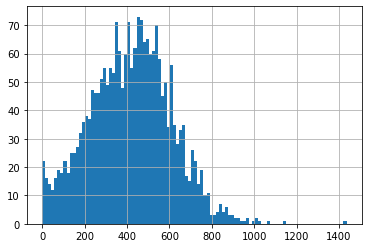

count    2228.000000
mean      418.100090
std       190.196645
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: duration, dtype: float64

422.0

0    437.0
dtype: float64

In [9]:
#Сколько минут разговора требуется пользователям каждого тарифа в месяц
smart['duration'].hist(bins=100) # распределение минут разговора в месяц
plt.show()
display(smart['duration'].describe())
display(smart['duration'].median())
display(smart['duration'].mode())


Распределение в целом стремится к нормальному. Есть выбросы в области около 1400 минут, потому что некоторые пользователи разговаривают дольше других. Но самое частое значение в выборке как раз находится около лимита в 500 минут: среднее - 419 минут, медиана - 423, мода - 437. Среднее меньше всех, т.к. на него влияет большая плотность значений в районе нуля. Стандартное отклонение - 189.

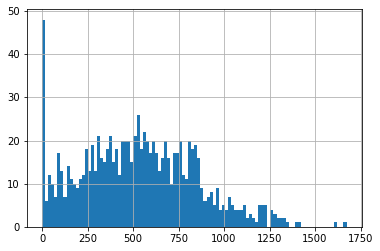

count     974.000000
mean      530.293634
std       317.330716
min         0.000000
25%       294.250000
50%       520.500000
75%       752.000000
max      1673.000000
Name: duration, dtype: float64

520.5

0    0.0
dtype: float64

In [10]:
#ультра звонки
ultra['duration'].hist(bins=100) # распределение минут разговора в месяц
plt.show()
display(ultra['duration'].describe())
display(ultra['duration'].median())
display(ultra['duration'].mode())

Здесь достаточно много пользователей, которые не разговаривают совсем, дисперсия несколько больше, чем у смартов, об этом говорит большое среднеквадратичное отклонение - 306. Одна из мод находится на отметке 567, медиана и среднее равны 531 и 548 соответственно, т.е. достаточно большое число тех, кто выбрал этот тариф, немного не укладывались в лимит смарта 500 минут

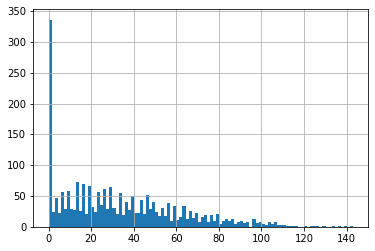

count    2228.000000
mean       33.398564
std        28.225868
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: message_date, dtype: float64

28.0

0    0.0
dtype: float64

In [11]:
#Сколько сообщений требуется пользователям каждого тарифа в месяц
smart['message_date'].hist(bins=100) # распределение количества сообщений в месяц
plt.show()
display(smart['message_date'].describe())
display(smart['message_date'].median())
display(smart['message_date'].mode())

С сообщениями история неоднозначна. Многие считают их бесполезными с появлением мессенджеров, некоторые продолжают использовать, отсюда и пик в области нуля. Но в среднем пользователи тарифа смарт отправляют почти 39 смс в месяц, пополам выборку делит значение в 34 смс, а вторая мода, кроме нуля, стоит на отметке в 20.

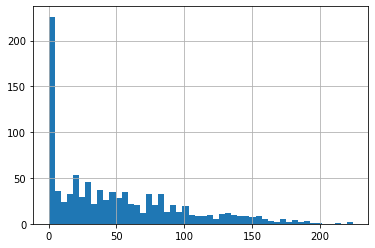

count    974.00000
mean      49.63655
std       47.97667
min        0.00000
25%        6.00000
50%       38.50000
75%       79.00000
max      224.00000
Name: message_date, dtype: float64

38.5

0    0.0
dtype: float64

In [12]:
# ультра смс
ultra['message_date'].hist(bins=50) # распределение количества сообщений в месяц
plt.show()
display(ultra['message_date'].describe())
display(ultra['message_date'].median())
display(ultra['message_date'].mode())


У пользователей тарифа ультра разброс значений шире, хотя, как и пользователи тарифа смарт, они нечасто используют смс, график скошен вправо, медиана меньше среднего.

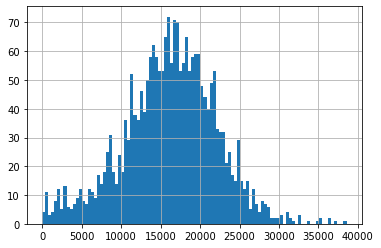

count     2228.000000
mean     16216.147217
std       5861.741010
min          0.000000
25%      12650.000000
50%      16508.000000
75%      20044.000000
max      38553.000000
Name: mb_used, dtype: float64

16508.0

0     7024
1    12404
2    13260
3    15522
4    17970
5    18911
dtype: int32

15.836081266831238

In [13]:
#Сколько интернета требуется пользователям каждого тарифа в месяц
smart['mb_used'].hist(bins=100) # распределение использованных мегабайт в месяц
plt.show()
display(smart['mb_used'].describe())
display(smart['mb_used'].median())
display(smart['mb_used'].mode())
display(smart['mb_used'].mean() / 1024)

В среднем, пользователи тарифа смарт нуждаются в 16 гигабайтах траффика в месяц, это немного превышает их лимит в 15 Гб. Форма гистограммы достаточно близка к гистограмме нормального распределения, пик находится примерно на 16 Гб, медиана и среднее находятся очень близко: 16 508 Мб и 16 216 Мб соответственно.

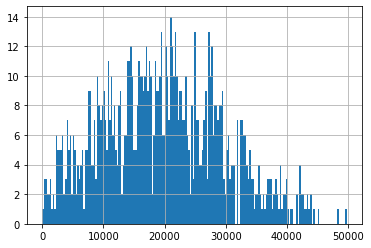

count      974.000000
mean     19688.636550
std       9929.211625
min          0.000000
25%      12062.500000
50%      19409.500000
75%      26912.500000
max      49746.000000
Name: mb_used, dtype: float64

19409.5

0      1445
1     10122
2     10929
3     13433
4     15615
5     16090
6     20479
7     22269
8     22819
9     23526
10    25105
11    25209
12    29290
dtype: int32

19.227184131160165

In [14]:
ultra['mb_used'].hist(bins=200) # распределение использованных мегабайт в месяц
plt.show()
display(ultra['mb_used'].describe())
display(ultra['mb_used'].median())
display(ultra['mb_used'].mode())
display(ultra['mb_used'].mean() / 1024)

Среди пользователей тарифа "ультра" разброс потраченных мегабайт траффика больше. Среднеквадратичное отклонение здесь составляет 9929 мегабайт, среднее примерно равно 19 688, а медиана находится на отметке 19409.5. Мод в этой выборке гораздо больше, чем среди "смартов", они разбросаны от 1445 мб до 29290 мб, если увеличить число корзин в гистограмме до нескольких тысяч, их можно будет увидеть. Самый высокий пик на гистограмме при количестве корзин 200 является, по всей видимости, слиянием пиков 20479 и 22269.

## 4. Проверка гипотез


Нулевая гипотеза:
средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковая
Альтернативная гипотеза:
средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Нулевая гипотеза:
средняя выручка пользователей из Москвы такая же как в других регионах
Альтернативная гипотеза:
средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Учитывая, что нужно сравнить средние двух выборок и определить вероятность равенства средних двух генеральных совокупностей, из которых взяты эти выборки, подойдёт метод scipy.stats.ttest_ind (array1, array2,equal_var).
Параметр equal_var в случае первой гипотезы можно заменить на False, т.к. дисперсия пользователей смарта заметно больше дисперсии пользователей тарифа ультра(1186 ^ 2 против 378 ^ 2), при сравнении пользователей из Москвы и из регионов дисперсия отличается не сильно.

In [19]:
# считаем среднюю выручку с каждого из тарифов
display(smart['sum_per_month'].describe())
display(ultra['sum_per_month'].describe())


count    2228.000000
mean     1747.172801
std      1186.358121
min       550.000000
25%       550.000000
50%      1550.000000
75%      2526.250000
max      8120.000000
Name: sum_per_month, dtype: float64

count     974.000000
mean     2071.509240
std       378.089373
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: sum_per_month, dtype: float64

In [25]:
sample_1 = smart['sum_per_month']
sample_2 = ultra['sum_per_month']
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.3794548312211954e-30
Отвергаем нулевую гипотезу


p оказался значительно меньше значения 0,05, это говорит о том, что разница между средними двух выборок статистически значима, а значит, говорить о равенстве средних двух выборок нельзя. Пользователи тарифа Ультра в среднем тратят на связь больше, чем пользователи тарифа Смарт. Такое же результат получается, даже если не применять параметр equal_var = False.

In [24]:
# теперь пришло время сравнить Москву и регионы
# сначала нужно подготовить выборки к анализу
Moscow_users = df.query('city == "Москва"')
Other_users = df.query('city != "Москва"')

sample_1 = Moscow_users['sum_per_month']
sample_2 = Other_users['sum_per_month']

alpha = .1# критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

display(Moscow_users['sum_per_month'].describe())
display(Other_users['sum_per_month'].describe())

p-значение:  0.534423787515256
Не получилось отвергнуть нулевую гипотезу


count     610.000000
mean     1822.691803
std       947.083887
min       550.000000
25%       950.000000
50%      1950.000000
75%      2174.250000
max      6671.000000
Name: sum_per_month, dtype: float64

count    2592.000000
mean     1851.276620
std      1039.198707
min       550.000000
25%       950.000000
50%      1950.000000
75%      2314.250000
max      8120.000000
Name: sum_per_month, dtype: float64

Значение p оказалось больше, чем 0,05 и даже больше, чем 0,1, а это значит что средние обеих выборок примерно равны, и скорее всего равны и средние генеральных совокупностей. В регионах на связь тратят примерно столько же, сколько в Москве.

## Вывод

Пользователи операторов мобильной связи очень разные, некоторые не пользуются звонками вообще, некоторые давно не отправляют смс. Действительно, мессенджеры заменили и то, и другое. Из всех, кто приобретал тарифы Смарт и Ультра, интернет-траффик использовали все. Несмотря на более стройные гистограммы средних затрат на звонки, смс и интернет, пользователи тарифа Смарт оказались более разнородными по прибыли, которую они приносят компании. Кто-то четко укладывается в лимиты по звонкам и смс, кто-то тратит гораздо больше и платит сверх абонентской платы. У пользователей тарифа Ультра выходов за пределы лимита меньше, но за счет изначально высокой абонентской платы, они приносят компании больше выручки. Как выяснилось с помощью t-теста, статистически значимо. 
Попытка выделить среди пользователей тарифов москвичей оказалась неудачной, средние затраты на связь почти не отличаются, а имеющаяся разница статистически не значима. 